In [1]:
import rospy
import tf
from nav_msgs.msg import Path
from nav_msgs.msg import Odometry
from tf.transformations import euler_from_quaternion, quaternion_from_euler
from PythonRobotics.PathPlanning.CubicSpline import cubic_spline_planner
import scipy.linalg as la
import matplotlib.pyplot as plt
import math
import numpy as np
import sys
import os
from geometry_msgs.msg import Twist

In [90]:
def get_rotation (msg):
    orientation_q = msg.pose.pose.orientation
    orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
    (roll, pitch, yaw) = euler_from_quaternion(orientation_list)
    return yaw


class State:

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v


class EE517Project():
    def __init__(self):
        rospy.init_node('final_project_ee517', anonymous=True)
        #self.init_odom = rospy.wait_for_message("/stickbug_base/zed/zed_node/odom", Odometry)
        self.init_odom = Odometry()
        self.init_odom.pose.pose.orientation.w = 1.0
        x = self.init_odom.pose.pose.position.x
        y = self.init_odom.pose.pose.position.y
        yaw = get_rotation(self.init_odom)
        self.init_state = State(x,y,yaw)
        self.old_vel_x = x
        self.old_vel_y = y
        rospy.Subscriber("/stickbug_base/zed/zed_node/odom", Odometry, self.odom_callback)
        self.cmd_vel_publisher = rospy.Publisher('/stickbug_base/cmd_vel', Twist, queue_size=10)
        self.vel = Twist()
    def odom_callback(self,msg):
        
        self.curr_x = msg.pose.pose.position.x
        self.curr_y = msg.pose.pose.position.y
        self.curr_yaw = get_rotation(msg)
        #print(self.curr_x)
        #print(self.old_vel_x)
        if self.curr_x != self.old_vel_y:
            _vel_x = (self.curr_x - self.old_vel_y)/0.66666667
        else:
            _vel_x = 0.0
        if self.curr_x != self.old_vel_y:
            _vel_y = (self.curr_x - self.old_vel_y)/0.66666667
        else:
            _vel_y = 0.0

        self.old_vel_x = self.curr_x
        self.old_vel_y = self.curr_y

        #print(self.curr_x)


        self.curr_vel = math.sqrt(math.pow(_vel_x,2)+math.pow(_vel_y,2))
        self.curr_state = State(self.curr_x,self.curr_y,self.curr_yaw)

    def update(self, a, delta):
        if delta >= max_steer:
            delta = max_steer
        if delta <= - max_steer:
            delta = - max_steer        
                
        self.vel.linear.x = a*math.cos(delta)
        #self.vel.linear.y = a*math.sin(delta)
        self.vel.angular.z = delta*0.25 
        #print(self.vel)
        self.cmd_vel_publisher.publish(self.vel)
        return self.vel.linear.x,self.vel.linear.y
        
    def closed_loop_prediction(self,cx, cy, cyaw, ck, speed_profile, goal):
        start_time = rospy.get_time()
        curr_time = rospy.get_time()-start_time
        T = 5.0  # max simulation time
        goal_dis = 0.1
        stop_speed = 0.05
        time = 0.0
        
        vel_x = []
        vel_y = []
        x = []
        y = []
        yaw = []
        v = []
        t = []
        ai_ = []
        dl_ = []
        
        e, e_th = 0.0, 0.0

        while 15 >= curr_time:
            curr_time = rospy.get_time()-start_time

            dl, target_ind, e, e_th = lqr_steering_control(
                self.curr_state, cx, cy, cyaw, ck, e, e_th)

            ai = PIDControl(speed_profile[target_ind], self.curr_state.v)
            
            _vel_x, _vel_y = self.update(ai,dl)
            rospy.sleep(0.1)
        
            curr_time = rospy.get_time()-start_time

            if abs(self.curr_state.v) <= stop_speed:
                target_ind += 1


            # check goal
            dx = self.curr_state.x - goal[0]
            dy = self.curr_state.y - goal[1]
            if math.hypot(dx, dy) <= goal_dis:
                print("Goal")
                self.cmd_vel_publisher.publish(Twist())
                break
                
            vel_x.append(_vel_x)
            vel_y.append(_vel_y)
            ai_.append(ai)
            dl_.append(dl)
            x.append(self.curr_state.x)
            y.append(self.curr_state.y)
            yaw.append(self.curr_state.yaw)
            v.append(self.curr_state.v)
            t.append(curr_time)

        #if target_ind % 1 == 0 and show_animation:
        #    plt.cla()
        #    # for stopping simulation with the esc key.
        #    plt.gcf().canvas.mpl_connect('key_release_event',
        #            lambda event: [exit(0) if event.key == 'escape' else None])
        #    plt.plot(cx, cy, "-r", label="course")
        #    plt.plot(x, y, "ob", label="trajectory")
        #    plt.plot(cx[target_ind], cy[target_ind], "xg", label="target")
        #    plt.axis("equal")
        ##    plt.grid(True)
        #    plt.title("speed[km/h]:" + str(round(state.v * 3.6, 2))
        #              + ",target index:" + str(target_ind))
        #    plt.pause(0.0001)
        if 12 <= curr_time:
            print("TIMED OUT")

        self.cmd_vel_publisher.publish(Twist())

        return ai_ ,dl_ ,t, x, y, yaw, v, vel_x, vel_y


In [91]:
ee517 = EE517Project()

In [92]:
def calc_speed_profile(cx, cy, cyaw, target_speed):
    speed_profile = [target_speed] * len(cx)

    direction = 1.0

    # Set stop point
    for i in range(len(cx) - 1):
        dyaw = abs(cyaw[i + 1] - cyaw[i])
        switch = math.pi / 4.0 <= dyaw < math.pi / 2.0

        if switch:
            direction *= -1

        if direction != 1.0:
            speed_profile[i] = - target_speed
        else:
            speed_profile[i] = target_speed

        if switch:
            speed_profile[i] = 0.0

    speed_profile[-1] = 0.0

    return speed_profile

In [93]:
ax = [ee517.curr_state.x, ee517.curr_state.x+0.5, ee517.curr_state.x+1, ee517.curr_state.x+0.75,ee517.curr_state.x+1.5]
ay = [ee517.curr_state.y, ee517.curr_state.y, ee517.curr_state.y-0.7, ee517.curr_state.y-1.25,ee517.curr_state.y-1.75]
goal = [ax[-1], ay[-1]]
#path = rospy.wait_for_message("/move_base/NavfnROS/plan", Path)
goal

ax_temp = np.array(ax)-ee517.curr_state.x
ay_temp = np.array(ay)-ee517.curr_state.y

In [94]:
cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=0.03)
target_speed = 0.38
speed_profile = calc_speed_profile(cx,cy,cyaw,target_speed)

Kp = 1.0  # speed proportional gain

# LQR parameter
Q = np.eye(4)
R = np.eye(1)

# parameters
dt = 0.1  # time tick[s]
L = 0.5  # Wheel base of the vehicle [m]
max_steer = np.deg2rad(35.0)  # maximum steering angle[rad]

In [95]:
ai, dl, t, x, y, yaw,v, vel_x, vel_y = ee517.closed_loop_prediction(cx, cy, cyaw, ck, speed_profile, goal)
ee517.cmd_vel_publisher.publish(vel)
rospy.sleep(1)
ee517.cmd_vel_publisher.publish(Twist())


TIMED OUT


In [53]:
vel = Twist()
vel.linear.x = 0.2

In [81]:
def PIDControl(target, current):
    a = Kp * (target - current)

    return a


def pi_2_pi(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi


def solve_DARE(A, B, Q, R):
    """
    solve a discrete time_Algebraic Riccati equation (DARE)
    """
    X = Q
    maxiter = 150
    eps = 0.01

    for i in range(maxiter):
        Xn = A.T @ X @ A - A.T @ X @ B @ \
            la.inv(R + B.T @ X @ B) @ B.T @ X @ A + Q
        if (abs(Xn - X)).max() < eps:
            break
        X = Xn

    return Xn


def dlqr(A, B, Q, R):
    """Solve the discrete time lqr controller.
    x[k+1] = A x[k] + B u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    # ref Bertsekas, p.151
    """

    # first, try to solve the ricatti equation
    X = solve_DARE(A, B, Q, R)

    # compute the LQR gain
    K = la.inv(B.T @ X @ B + R) @ (B.T @ X @ A)

    eigVals, eigVecs = la.eig(A - B @ K)

    return K, X, eigVals


def lqr_steering_control(state, cx, cy, cyaw, ck, pe, pth_e):
    ind, e = calc_nearest_index(state, cx, cy, cyaw)

    k = ck[ind]
    v = state.v
    th_e = pi_2_pi(state.yaw - cyaw[ind])

    A = np.zeros((4, 4))
    A[0, 0] = 1.0
    A[0, 1] = dt
    A[1, 2] = v
    A[2, 2] = 1.0
    A[2, 3] = dt
    # print(A)

    B = np.zeros((4, 1))
    B[3, 0] = v / L

    K, _, _ = dlqr(A, B, Q, R)

    x = np.zeros((4, 1))

    x[0, 0] = e
    x[1, 0] = (e - pe) / dt
    x[2, 0] = th_e
    x[3, 0] = (th_e - pth_e) / dt

    ff = math.atan2(L * k, 1)
    fb = pi_2_pi((-K @ x)[0, 0])

    delta = ff + fb

    return delta, ind, e, th_e


def calc_nearest_index(state, cx, cy, cyaw):
    dx = [state.x - icx for icx in cx]
    dy = [state.y - icy for icy in cy]

    d = [idx ** 2 + idy ** 2 for (idx, idy) in zip(dx, dy)]

    mind = min(d)

    ind = d.index(mind)

    mind = math.sqrt(mind)

    dxl = cx[ind] - state.x
    dyl = cy[ind] - state.y

    angle = pi_2_pi(cyaw[ind] - math.atan2(dyl, dxl))
    if angle < 0:
        mind *= -1

    return ind, mind

In [71]:
x

[-2.1748452745995217,
 -2.1748452709436825,
 -2.174845269115763,
 -2.1748452654599237,
 -2.174855369165464,
 -2.174935778895153,
 -2.175404847860776,
 -2.1734373450223634,
 -2.170961268640503,
 -2.1687094710775074,
 -2.163577506933239,
 -2.1607725095409265,
 -2.151372340585511,
 -2.1461903287986743,
 -2.137293971513942,
 -2.128197186820619,
 -2.123846956855956,
 -2.1140565105236426,
 -2.1079722081839196,
 -2.097473069495097,
 -2.0922932985395195,
 -2.082303388125336,
 -2.077279452692611,
 -2.067267154427335,
 -2.05776507565148,
 -2.0526521044563144,
 -2.042476315778373,
 -2.0375877557478064,
 -2.027563834699183,
 -2.0225280351221633,
 -2.01232474441523,
 -2.0070124063341317,
 -1.9960616255402646,
 -1.9858958760621666,
 -1.9808073154191248,
 -1.9701966170619425,
 -1.9650410148230932,
 -1.9537764529770567,
 -1.9486925330612126,
 -1.939064468646584,
 -1.930024295793365,
 -1.9253016900430233,
 -1.9163334185626795,
 -1.9118060106286303,
 -1.9023928073470495,
 -1.8971751266373584,
 -1.888300

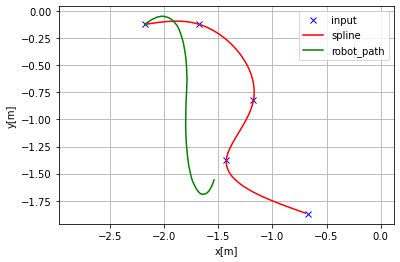

In [73]:
        plt.subplots(1)
        plt.plot(ax, ay, "xb", label="input")
        plt.plot(cx, cy, "-r", label="spline")
        plt.plot(x, y, "-g", label="robot_path")
        #plt.plot(x, y, "-g", label="tracking")
        plt.grid(True)
        plt.axis("equal")
        plt.xlabel("x[m]")
        plt.ylabel("y[m]")
        plt.legend()

In [78]:
min(cx)

-2.174918176426081

In [80]:
min(x)

-2.175404847860776

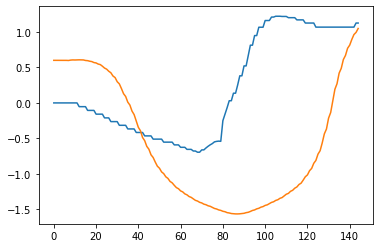

In [89]:
plt.subplots(1)
plt.plot(dl)
plt.plot(yaw)